Learning to rank.


In [1]:
from wvpy.jtools import declare_task_variables

# set up for external override
with declare_task_variables(globals()):
    rand_seed = 2024
    do_display = True
    result_fname = ""
    m_train_examples = 100
    score_name = "quality"
    clean_up = False
    show_console = False
    generative_noise_scale = 0.87
    scoring_noise_scale = 2.0
    continue_inspection_probability = 0.8
    price_limit_mean = 40
    price_limit_var = 5


In [2]:
# set up Python
import logging
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from scipy.stats import spearmanr
from plotnine import *
from rank_plotting_fns import (
    define_Stan_inspection_src,
    estimate_model_from_scores,
    format_Stan_inspection_data,
    mk_example,
    plot_rank_performance,
    run_stan_model,
)

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

In [3]:
rng = np.random.default_rng(rand_seed)

In [4]:
example_name = "uci wine example"
price_limit_scale = price_limit_var / price_limit_mean
price_limit_shape = price_limit_mean**2 / price_limit_var

In [5]:
if do_display:
    print(example_name)

uci wine example


In [6]:

# read data and set scale of system
features_frame = pd.read_csv("uci_wine_example_features.csv")
features_scores = pd.read_csv("uci_wine_example_scores.csv")
m_test_examples: int = 2000
n_item_features = features_frame.shape[1]


know_score: bool = True

In [7]:
features_frame.head()

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red,price
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,23.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,21.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,26.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,27.0


In [8]:
features_frame.shape

(6497, 24)

In [9]:
collected_stats = []

In [10]:
n_alternatives: int = 5

In [11]:
n_vars = features_frame.shape[1] + n_alternatives

Continue inspection probability:

In [12]:


continue_inspection_probability


0.8

In [13]:
observations_train = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_inspection_probability=continue_inspection_probability,
    n_alternatives=n_alternatives,
    m_examples=m_train_examples,
    score_name=score_name,
    noise_scale=generative_noise_scale,
    price_limit_shape=price_limit_shape,
    price_limit_scale=price_limit_scale,
    rng=rng,
)

In [14]:
observations_test = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_inspection_probability=continue_inspection_probability,
    n_alternatives=n_alternatives,
    m_examples=m_test_examples,
    score_name=score_name,
    noise_scale=generative_noise_scale,
    price_limit_shape=price_limit_shape,
    price_limit_scale=price_limit_scale,
    rng=rng,
)

In [15]:
perfect_coef = None
if know_score:
    perfect_coef = estimate_model_from_scores(
            observations=observations_train,
            features_frame=features_frame,
        )

In [16]:
# make sure we don't have a column we would not know in practice
observations_train = observations_train.loc[
    :, [c for c in observations_train.columns if not (c.startswith("score_value_") or (c == "price_limit"))]
].reset_index(drop=True, inplace=False)
observations_test = observations_test.loc[
    :, [c for c in observations_test.columns if not (c.startswith("score_value_") or (c == "price_limit"))]
].reset_index(drop=True, inplace=False)

observations_train.head()

,display_position_0,item_id_0,pick_value_0,price_0,display_position_1,item_id_1,pick_value_1,price_1,display_position_2,item_id_2,pick_value_2,price_2,display_position_3,item_id_3,pick_value_3,price_3,display_position_4,item_id_4,pick_value_4,price_4
0,0,1569,1,29.0,1,940,0,39.0,2,3566,0,30.0,3,3910,0,33.0,4,3218,0,46.0
1,0,4390,1,19.0,1,1583,0,22.0,2,1694,0,25.0,3,3437,0,32.0,4,4848,0,34.0
2,0,599,1,30.0,1,3548,0,30.0,2,1645,0,13.0,3,1792,0,17.0,4,3523,0,18.0
3,0,1392,0,23.0,1,3348,0,29.0,2,6223,1,27.0,3,5688,0,36.0,4,3012,0,31.0
4,0,2063,0,23.0,1,905,0,23.0,2,2812,0,29.0,3,3915,1,35.0,4,3134,0,31.0


In [17]:
win_frequencies = (
    observations_train
        .loc[
            :, 
            [c for c in observations_train.columns if c.startswith("pick_value_")]]
        .mean(axis=0)
        .reset_index(drop=False, inplace=False)
        .sort_values(['index'], ignore_index=True)
)
win_frequencies.columns = ['position', 'win frequency']

win_frequencies

,position,win frequency
0,pick_value_0,0.37
1,pick_value_1,0.22
2,pick_value_2,0.18
3,pick_value_3,0.13
4,pick_value_4,0.09


In [18]:
# This is the observable data
observations_train[
    [c for c in observations_train.columns if not c.startswith("display_position_")]
].head(10)

,item_id_0,pick_value_0,price_0,item_id_1,pick_value_1,price_1,item_id_2,pick_value_2,price_2,item_id_3,pick_value_3,price_3,item_id_4,pick_value_4,price_4
0,1569,1,29.0,940,0,39.0,3566,0,30.0,3910,0,33.0,3218,0,46.0
1,4390,1,19.0,1583,0,22.0,1694,0,25.0,3437,0,32.0,4848,0,34.0
2,599,1,30.0,3548,0,30.0,1645,0,13.0,1792,0,17.0,3523,0,18.0
3,1392,0,23.0,3348,0,29.0,6223,1,27.0,5688,0,36.0,3012,0,31.0
4,2063,0,23.0,905,0,23.0,2812,0,29.0,3915,1,35.0,3134,0,31.0
5,2010,1,23.0,831,0,32.0,1340,0,30.0,2792,0,26.0,1227,0,23.0
6,5903,1,29.0,2600,0,25.0,678,0,18.0,4695,0,45.0,4375,0,45.0
7,5194,1,39.0,4768,0,35.0,5948,0,23.0,4440,0,18.0,162,0,27.0
8,5946,0,25.0,289,0,24.0,3299,0,37.0,5215,0,30.0,1390,1,35.0
9,6469,1,41.0,4500,0,43.0,1575,0,22.0,216,0,20.0,248,0,28.0


In [19]:
score_compare_frame = pd.DataFrame([[] for i in range(features_frame.shape[0])])
if know_score:
    score_compare_frame["hidden concept"] = features_scores[
        score_name
    ]  # would not know this for non-synthetic data

Try a Stan model.


In [20]:
stan_model_inspection_src = define_Stan_inspection_src(n_alternatives=n_alternatives)
if do_display:
    print(stan_model_inspection_src)



data {
  int<lower=1> n_vars;  // number of variables per alternative
  int<lower=5, upper=5> n_alternatives;  // number of alternatives
  int<lower=1> m_examples;  // number of examples
  array[m_examples, n_alternatives] real<lower=0> price; // price of each item
  array[m_examples, n_alternatives] int<lower=0, upper=1> picked_indicator;  // picked position indicator
  array[m_examples] int<lower=0, upper=1> n_picks_seen;  // number marked picks per alternative
  matrix[m_examples, n_vars] x_1;  // features examples
  matrix[m_examples, n_vars] x_2;  // features examples
  matrix[m_examples, n_vars] x_3;  // features examples
  matrix[m_examples, n_vars] x_4;  // features examples
  matrix[m_examples, n_vars] x_5;  // features examples
}
parameters {
  real<lower=0, upper=1> p_continue;  // modeled probability of inspecting on
  vector[n_vars] beta;  // model parameter
  vector[m_examples] price_limit;  // upper bound on price willing to spend
  array[n_alternatives] vector[m_exampl

In [21]:
data_inspection_str = format_Stan_inspection_data(
    observations=observations_train,
    features_frame=features_frame,
)

In [22]:
fit_inspection = run_stan_model(
    stan_model_src=stan_model_inspection_src,
    data_str=data_inspection_str,
    model_note='inspection_model',
    clean_up=clean_up,
    show_console=show_console,
)

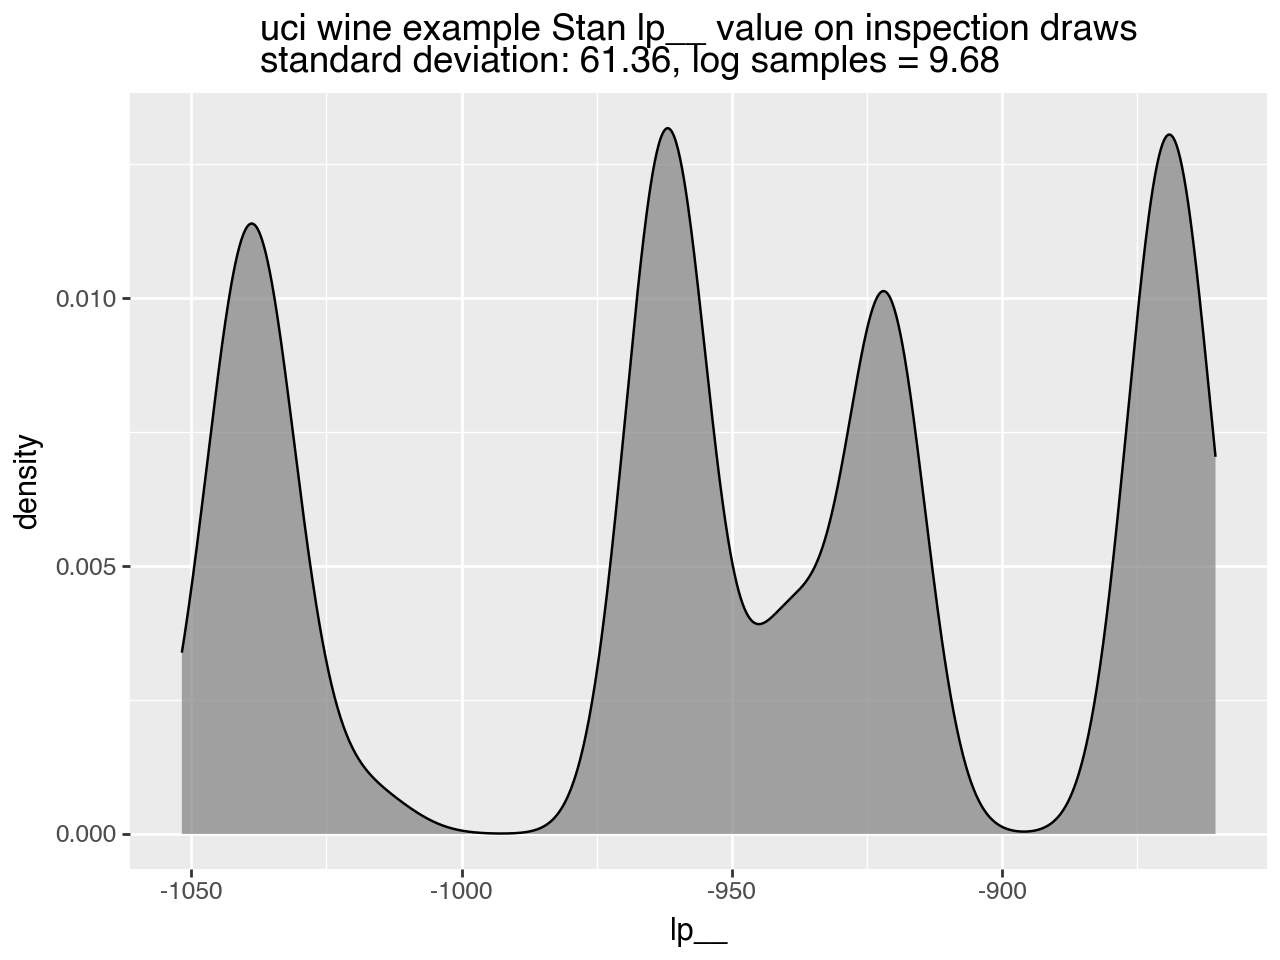

In [23]:
# get implied sample weights from chain
wt_frame_inspection = fit_inspection.draws_pd(vars=["lp__"])

if do_display:
    stddev = np.sqrt(np.var(wt_frame_inspection["lp__"]))
    log_samples = np.log(wt_frame_inspection.shape[0])
    (
        ggplot(
            data=wt_frame_inspection,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on inspection draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
        )
    ).show()

Estimated inspection continuation probability.

In [24]:
est_p_continue = np.mean(fit_inspection.draws_pd(vars=["p_continue"]))

est_p_continue

0.6404424092500001

Estimated betas.

In [25]:
beta_draws = fit_inspection.draws_pd(vars=["beta"])
beta_draws_display = beta_draws.copy()
beta_draws_display.columns = list(features_frame.columns) 

beta_draws_display

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red,price
0,15.8304,-8.39750,13.91120,4.68698,10.65160,8.76799,10.03780,-9.15531,14.32770,2.10333,...,10.1244,10.2520,8.10525,8.36800,-11.77360,-2.32570,-7.55727,5.92598,-18.35130,-5.87657
1,15.7070,-8.39519,13.88250,4.68631,10.59700,8.79749,10.03270,-9.19159,14.42420,2.02063,...,10.1257,10.2346,8.08757,8.36528,-11.77480,-2.31471,-7.54805,5.91369,-18.36040,-5.86348
2,15.6995,-8.37221,13.88760,4.68595,10.61520,8.77648,10.03220,-9.20222,14.44890,2.02130,...,10.1107,10.2443,8.06703,8.36116,-11.76760,-2.31860,-7.54442,5.91350,-18.35850,-5.85972
3,15.8079,-8.36196,13.89340,4.69216,10.59330,8.77835,10.03830,-9.19718,14.56250,1.99778,...,10.1228,10.2648,8.13505,8.40154,-11.79060,-2.34240,-7.56525,5.89571,-18.29870,-5.87639
4,15.7909,-8.35308,13.91050,4.69263,10.60910,8.78308,10.04380,-9.21228,14.49110,1.99452,...,10.1810,10.2724,8.12113,8.40262,-11.78710,-2.34506,-7.55941,5.89769,-18.26630,-5.86654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,13.3749,3.58144,4.41259,1.28756,-2.93654,7.37295,-7.89143,6.02983,2.64660,-17.01120,...,13.2641,14.6130,-1.70470,-1.19876,-8.25919,13.65740,4.33647,10.83940,-3.44003,13.19050
15996,13.3777,3.57925,4.41474,1.29465,-2.93465,7.38183,-7.89101,6.02868,2.62443,-17.01680,...,13.2625,14.6101,-1.69548,-1.19782,-8.26021,13.67360,4.35522,10.81340,-3.43632,13.18400
15997,13.3759,3.57613,4.40938,1.28785,-2.93027,7.45121,-7.89406,6.02901,2.63079,-17.01480,...,13.2662,14.6171,-1.69043,-1.20040,-8.20662,13.68510,4.47312,10.83540,-3.46325,13.16140
15998,13.3685,3.59371,4.41515,1.30227,-2.91848,7.37533,-7.89071,6.02294,2.52962,-17.02590,...,13.2632,14.6601,-1.67853,-1.18832,-8.01366,13.65350,4.65795,10.76390,-3.44181,13.06400


In [26]:
# this this entirety of what we pull out of Stan- per modeled preference cohort
# from now on we do not use Stan
estimated_beta_inspection_Stan = beta_draws_display.loc[
    wt_frame_inspection["lp__"] >= np.quantile(wt_frame_inspection["lp__"], 0.75), :
].mean()

estimated_beta_inspection_Stan

fixed acidity is red              2.675077
volatile acidity is red          -9.353614
citric acid is red               -0.846786
residual sugar is red            -1.346887
chlorides is red                 -2.523410
free sulfur dioxide is red       -7.482791
total sulfur dioxide is red      -3.795683
density is red                    6.949170
pH is red                         4.725690
sulphates is red                 -6.171594
alcohol is red                    3.139609
fixed acidity is white          -21.030070
volatile acidity is white        -4.917634
citric acid is white              0.588392
residual sugar is white           0.776163
chlorides is white               -3.207353
free sulfur dioxide is white      4.401849
total sulfur dioxide is white    -0.394413
density is white                 -6.894179
pH is white                      -0.340550
sulphates is white               -0.643371
alcohol is white                  9.510284
is_red                           -4.278085
price      

In [27]:
estimated_beta_inspection_Stan = list(estimated_beta_inspection_Stan)

picks


,row,position,pick probability estimate,was pick
0,0,0,9.999996e-01,False
1,0,1,9.999995e-08,False
2,0,2,9.999995e-08,True
3,0,3,9.999995e-08,False
4,0,4,9.999995e-08,False
5,1,0,3.099999e-01,True
6,1,1,9.999995e-08,False
7,1,2,1.500000e-01,False
8,1,3,5.399998e-01,False
9,1,4,9.999995e-08,False


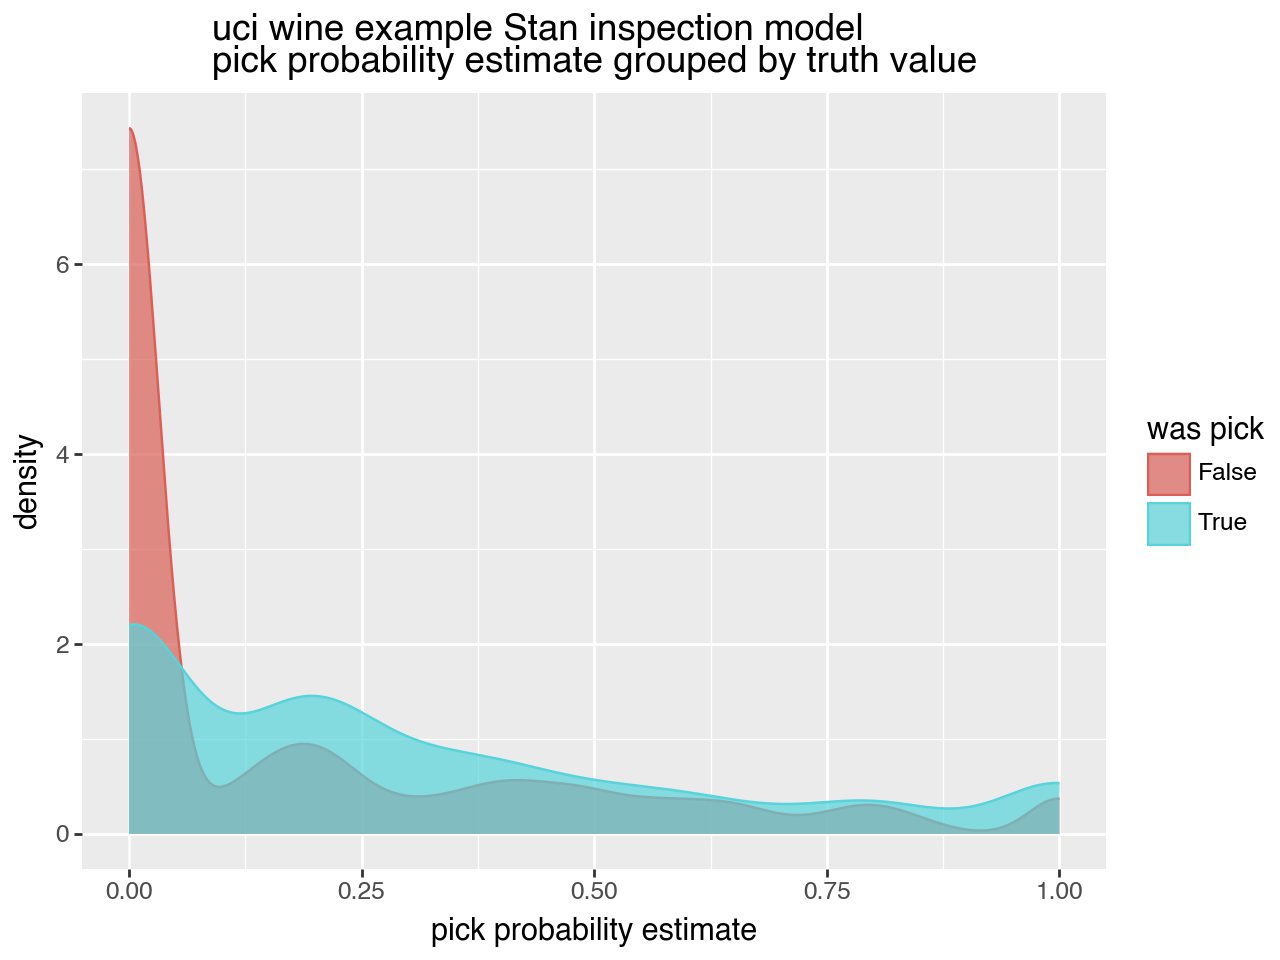

<Figure size 640x480 with 0 Axes>

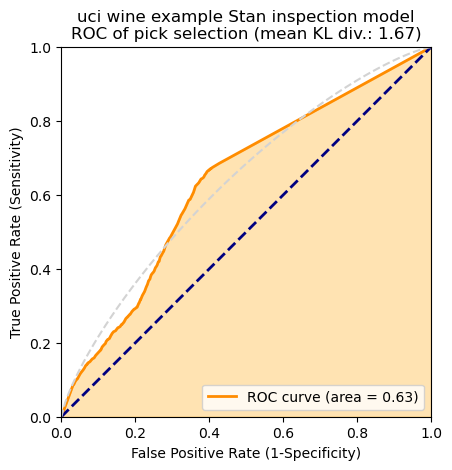

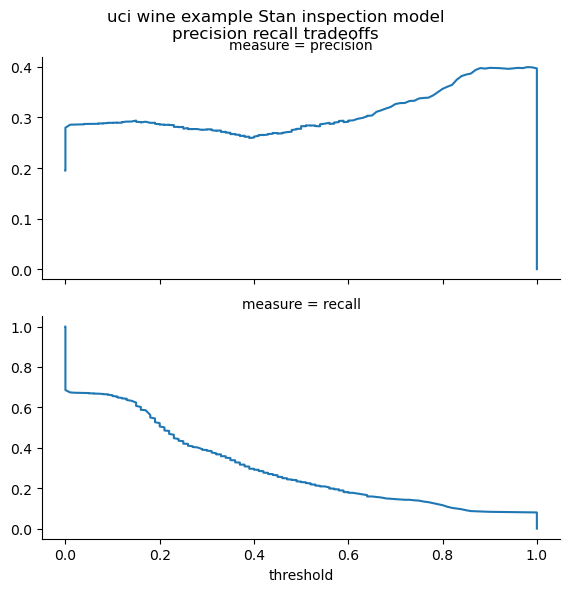

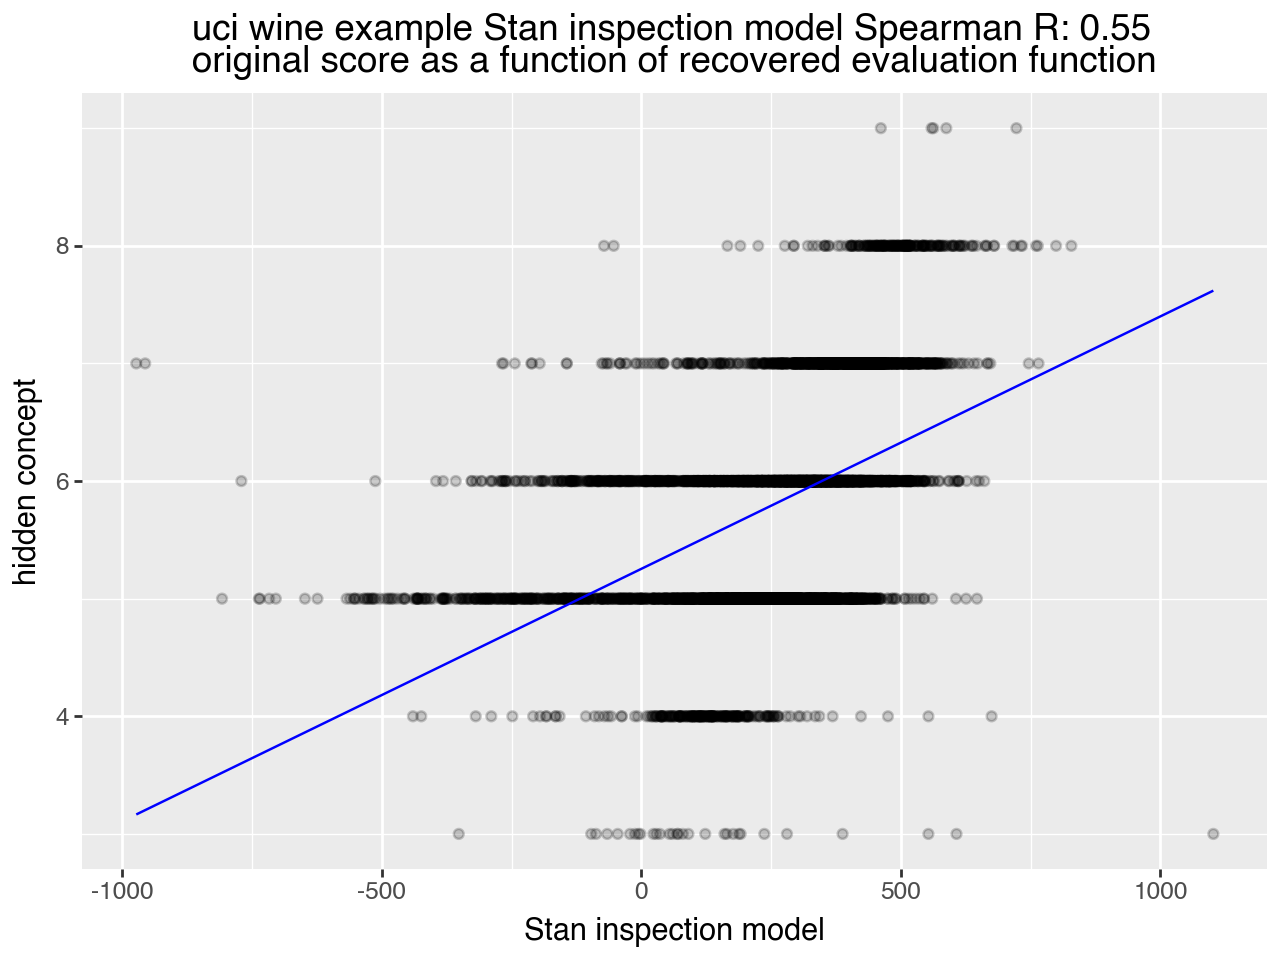

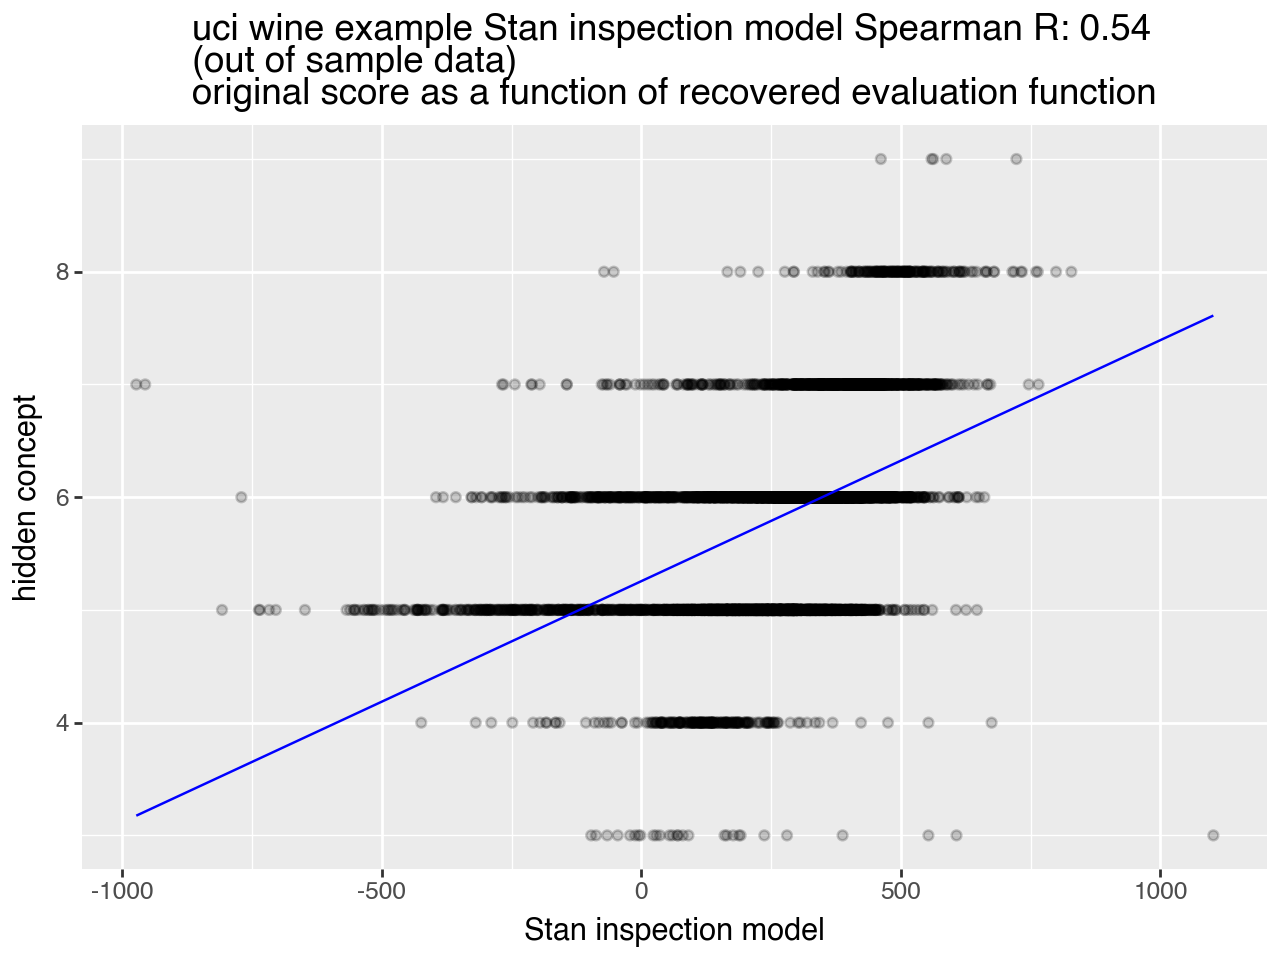

In [28]:
stat_pull_inspection_Stan = plot_rank_performance(
    model=estimated_beta_inspection_Stan,  # estimated coefficients
    model_type='coef',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of lists
    simulation_sigma=scoring_noise_scale,  # noise level in utility/score
    continue_inspection_probability=continue_inspection_probability,  # probability of inspecting next element
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name="Stan inspection model",  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
stat_pull_inspection_Stan['extra_info'] = f'{{"est_p_continue": {est_p_continue}}}'
collected_stats.append(stat_pull_inspection_Stan)

Trying a model on directly on single items.

In [29]:
def fit_logistic_items() -> None:
    # encode items (with position)
    feature_names = list(features_frame.columns) + [
            f"position_{sel_i}" for sel_i in range(n_alternatives)
    ]
    item_enc_frame = []
    item_outcomes = []
    for row_i in range(observations_train.shape[0]):
        feature_row = observations_train.loc[row_i, :]
        for sel_i in range(n_alternatives):
            posn_vec = [0] * n_alternatives
            posn_vec[sel_i] = 1.0
            encoded_row = list(
                    features_frame.loc[feature_row[f"item_id_{sel_i}"], :]
                ) + posn_vec
            ri = pd.DataFrame({k: [v] for k, v in zip(feature_names, encoded_row)})
            item_enc_frame.append(ri)
            item_outcomes.append(feature_row[f"pick_value_{sel_i}"] == 1)
    item_enc_frame = pd.concat(item_enc_frame, ignore_index=True)
    classification_model_items = LogisticRegression(max_iter=10000, solver="newton-cholesky")
    classification_model_items.fit(
        X=item_enc_frame,
        y=item_outcomes,
    )
    stat_pull_items_classifier = plot_rank_performance(
        model=classification_model_items.coef_[0][range(features_frame.shape[1])],
        model_type='coef',
        example_name=example_name,  # name of data set
        n_alternatives=n_alternatives,  # size of lists
        simulation_sigma=scoring_noise_scale,  # noise level in utility/score
        continue_inspection_probability=continue_inspection_probability,  # probability of inspecting next element
        features_frame=features_frame,  # features by row id
        observations_train=observations_train,  # training observations layout frame
        observations_test=observations_test,  # evaluation observations layout frame
        estimate_name='logistic items',  # display name of estimate
        score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
        rng=rng,  # pseudo random source
        show_plots=False,
    )
    collected_stats.append(stat_pull_items_classifier)

In [30]:

fit_logistic_items()

We can compare this to just looking at the scores (not implementable in real world problems).

picks


,row,position,pick probability estimate,was pick
0,0,0,0.57,False
1,0,1,0.22,False
2,0,2,0.11,True
3,0,3,0.06,False
4,0,4,0.04,False
5,1,0,0.40,True
6,1,1,0.15,False
7,1,2,0.16,False
8,1,3,0.12,False
9,1,4,0.17,False


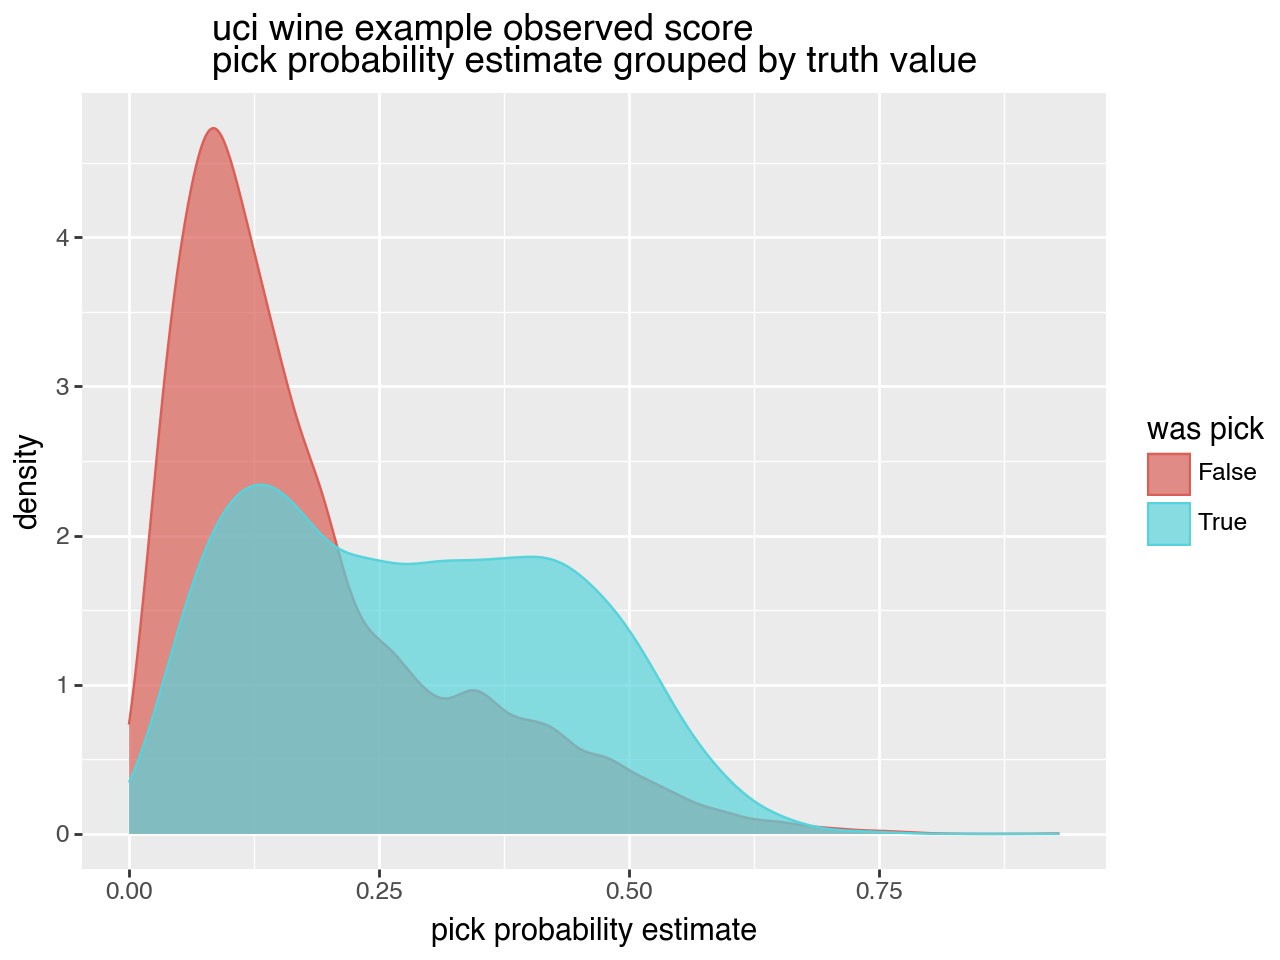

<Figure size 640x480 with 0 Axes>

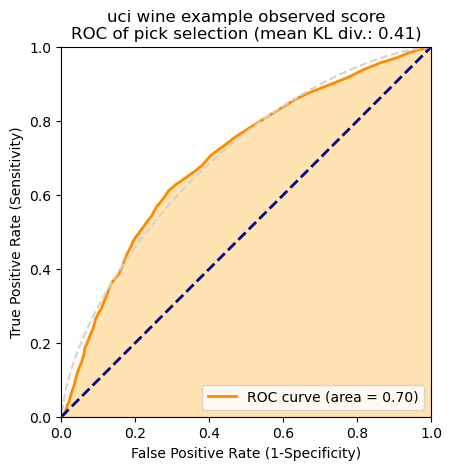

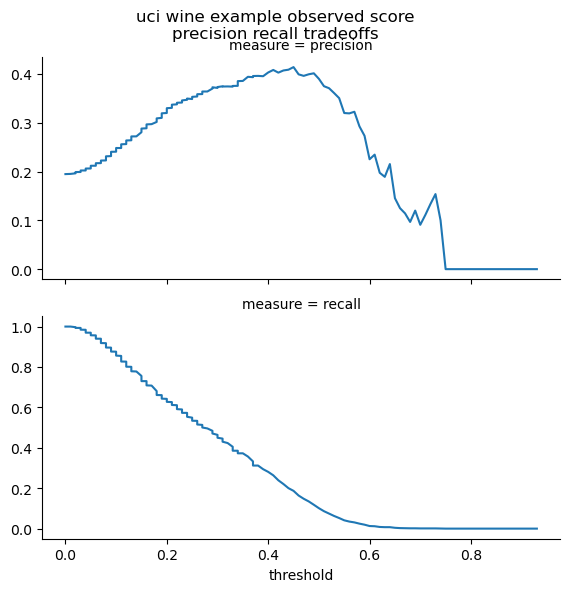

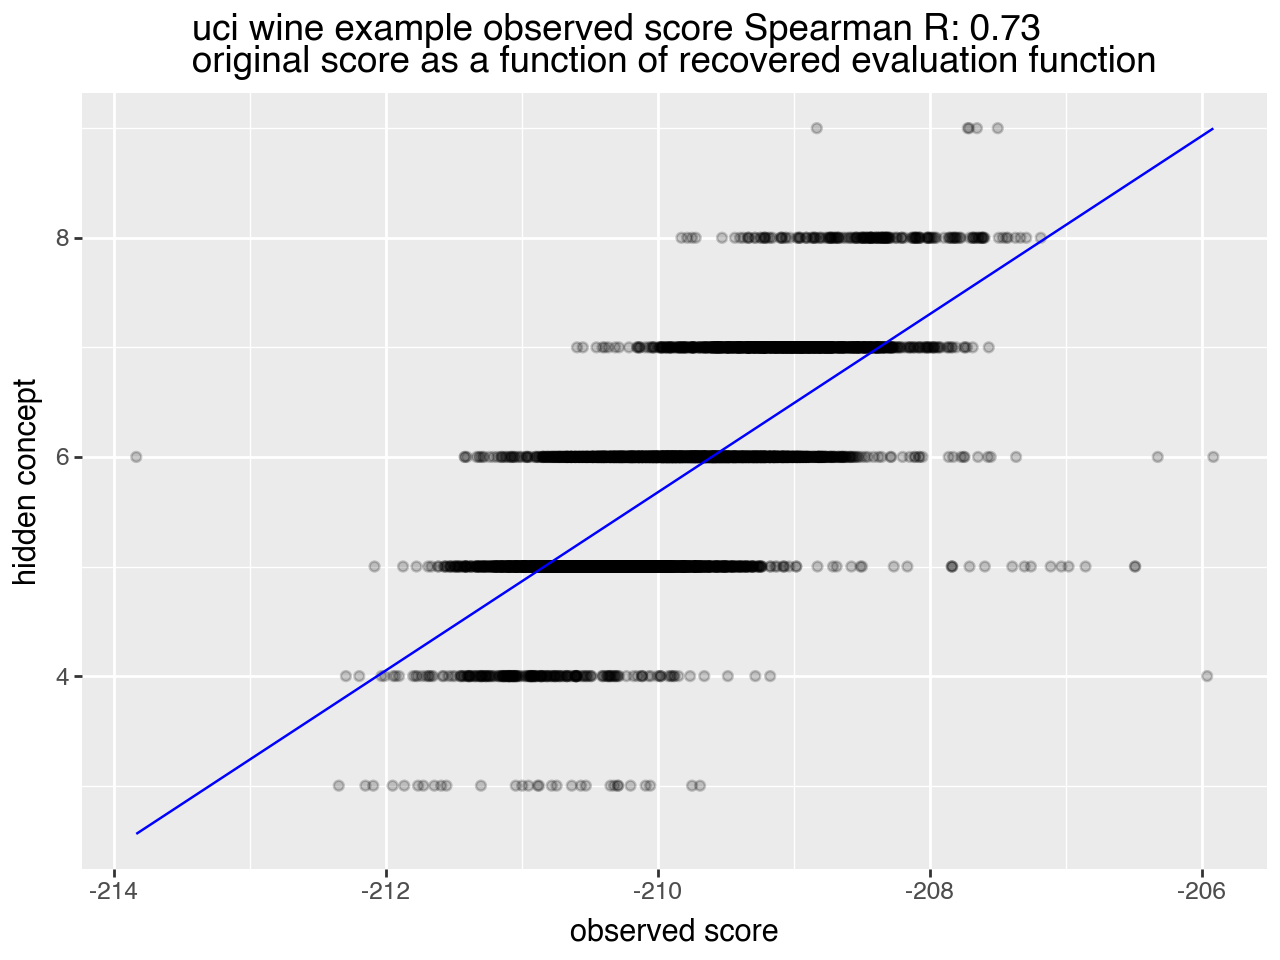

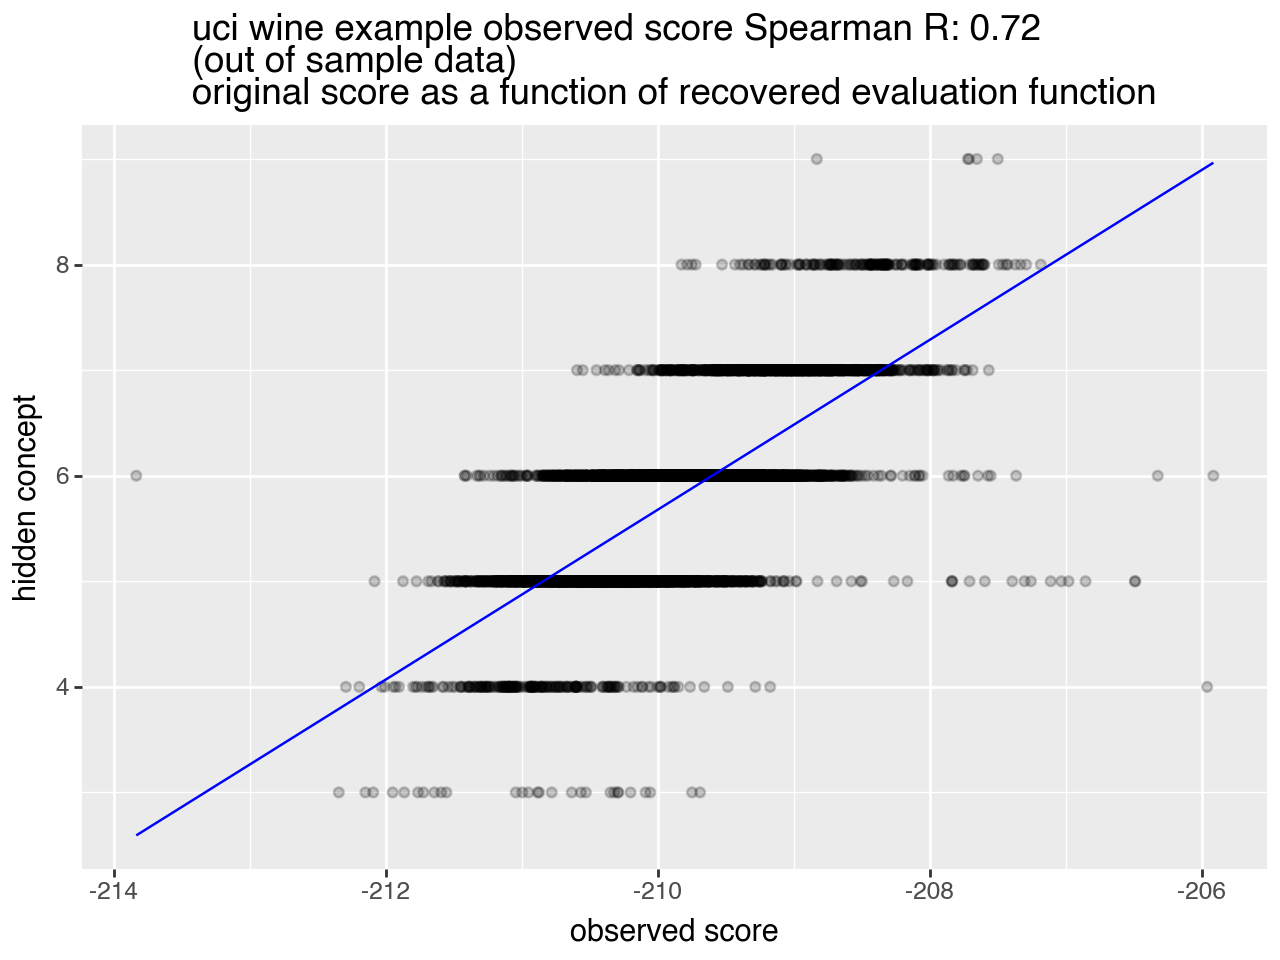

In [31]:
# plug in the perfect model that saw the scores
if know_score and (perfect_coef is not None):
    perfect_pull = plot_rank_performance(
        model=perfect_coef[range(features_frame.shape[1])],  # estimated coefficients
        model_type='coef',
        example_name=example_name,  # name of data set
        n_alternatives=n_alternatives,  # size of lists
        simulation_sigma=scoring_noise_scale,  # noise level in utility/score
        continue_inspection_probability=continue_inspection_probability,  # probability of inspecting next element
        features_frame=features_frame,  # features by row id
        observations_train=observations_train,  # training observations layout frame
        observations_test=observations_test,  # evaluation observations layout frame
        estimate_name="observed score",  # display name of estimate
        score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
        rng=rng,  # pseudo random source
        show_plots=do_display,
    )
    collected_stats.append(perfect_pull)

In [32]:
collected_stats = pd.concat(collected_stats, ignore_index=True)


In [33]:
collected_stats['score_name'] = score_name
collected_stats['p_continue'] = continue_inspection_probability
collected_stats['generative_noise_scale'] = generative_noise_scale
collected_stats['scoring_noise_scale'] = scoring_noise_scale


In [34]:
if (result_fname is not None) and (len(result_fname) > 0):
    collected_stats.to_csv(result_fname, index=False)

In [35]:
if do_display:
    display(collected_stats)

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc_test,pick_KL_div_test,training_lists,test_lists,data_size,test_size,extra_info,score_name,p_continue,generative_noise_scale,scoring_noise_scale
0,uci wine example,Stan inspection model,0.545528,0.542555,0.633711,1.674183,100,2000,6497,6022,"{""est_p_continue"": 0.6404424092500001}",quality,0.8,0.87,2.0
1,uci wine example,logistic items,0.355726,0.352995,0.696940,0.409160,100,2000,6497,6022,,quality,0.8,0.87,2.0
2,uci wine example,observed score,0.726506,0.724106,0.699049,0.413110,100,2000,6497,6022,,quality,0.8,0.87,2.0
